In [1]:
import numpy as np
import os
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import time

/home/zhesu157/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_path = 'train.txt'
valid_path = 'valid.txt'
test_path = 'test.txt'

# Load data
def load_data(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        data = []
        for line in lines:
            data.append(line.strip())
        return data

train_data = load_data(train_path)
valid_data = load_data(valid_path)
test_data = load_data(test_path)

In [4]:
print('Number of training tokens:', len(train_data))
print('Number of validation tokens:', len(valid_data))
print('Number of test tokens:', len(test_data))

for i in range(5):
    random_index = np.random.randint(0, len(train_data))
    print('Sample:', train_data[random_index])
    
print('First 10 training tokens:', train_data[:10])

Number of training tokens: 42068
Number of validation tokens: 3370
Number of test tokens: 3761
Sample: the N <unk> funds increased $ N billion to $ N billion while N broker-dealer funds increased $ N billion to $ N billion
Sample: about N N of picop is publicly traded and other shareholders own the rest of the equity
Sample: a financial adviser for revco bondholders david <unk> of <unk> partners had mixed reactions to the offer
Sample: jacobs is an international engineering and construction concern
Sample: on the <unk> streets of <unk> mahfouz 's cairo life is nasty <unk> and <unk> entertaining
First 10 training tokens: ['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing group', 'rudolph <unk> N years old and former chairma

In [5]:
#1.3
def add_eos(data):
    return [line + ' <eos>' for line in data]

train_data = add_eos(train_data)
valid_data = add_eos(valid_data)
test_data = add_eos(test_data)

print('First 10 training tokens:', train_data[:10])

First 10 training tokens: ['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos>', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos>', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos>', 'rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate <eos>', 'a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported <eos>', 'the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said <eos>', '<unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in

In [6]:
#1.4
def calculate_words_number(data):
    return len(' '.join(data).split(' '))

print('Number of training words:', calculate_words_number(train_data))
print('Number of validation words:', calculate_words_number(valid_data))
print('Number of test words:', calculate_words_number(test_data))

Number of training words: 929589
Number of validation words: 73760
Number of test words: 82430


In [7]:
total_number = calculate_words_number(train_data) + calculate_words_number(valid_data) + calculate_words_number(test_data)
print('Total number of words:', total_number)

Total number of words: 1085779


In [8]:
#1.5
def freq_dict(data):
    words = ' '.join(data).split(' ')
    unique, counts = np.unique(words, return_counts=True)
    return dict(zip(unique, counts))

dict_all = freq_dict(train_data+valid_data+test_data)
print('Number of unique words:', len(dict_all))


Number of unique words: 10000


In [9]:
train_data = ' '.join(train_data).split(' ')
valid_data = ' '.join(valid_data).split(' ')
test_data = ' '.join(test_data).split(' ')

In [10]:
print('Number of unique words in train:', len(freq_dict(train_data)))
print('Number of unique words in valid:', len(freq_dict(valid_data)))
print('Number of unique words in test:', len(freq_dict(test_data)))


Number of unique words in train: 10000
Number of unique words in valid: 6022
Number of unique words in test: 6049


In [11]:

# Build vocabulary
def build_vocab(data):
    vocab = {}
    for word in data:
        if word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# Convert data to indices
def convert_to_indices(data, vocab):
    return [vocab[word] for word in data]

# Create batches
def create_batches(data, batch_size, seq_len):
    num_batches = len(data) // batch_size
    data = data[:num_batches * batch_size]
    data = np.array(data)

    return data.reshape(batch_size, -1)


In [12]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
data_all = train_data + valid_data + test_data
vocab = build_vocab(data_all)
int_to_word = dict((i, c) for i, c in enumerate(vocab))

# Convert data to indices
train_data = convert_to_indices(train_data, vocab)
valid_data = convert_to_indices(valid_data, vocab)
test_data = convert_to_indices(test_data, vocab)

# Create batches
batch_size = 20
seq_len = 30
train_data = create_batches(train_data, batch_size, seq_len)
valid_data = create_batches(valid_data, batch_size, seq_len)
test_data = create_batches(test_data, batch_size, seq_len)

In [13]:

    
def train(model, model_type, train_data, valid_data, vocab_size, seq_len, batch_size, num_epochs, learning_rate, device, clip=0):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    valid_losses = []
    train_perplexities = []
    valid_perplexities = []

    num_batches = len(train_data[0]) // seq_len
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        hidden = model.init_hidden(batch_size)
        for i in range(0, len(train_data[0,:]) - seq_len, seq_len):
            inputs = torch.from_numpy(train_data[:,i:i+seq_len]).to(device)
            targets = torch.from_numpy(train_data[:,(i+1):(i+1)+seq_len]).to(device)

            if model_type == 'LSTM':
                hidden = [h.data.to(device) for h in hidden]
            else:
                hidden = hidden.data.to(device)

            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

            model.zero_grad()
            loss.backward()
            if clip != 0:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            
            train_loss.append(loss.item())  
            
            step = (i+1) // seq_len
            if step % 100 == 0:
                print ('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                        .format(epoch+1, num_epochs, step, num_batches, loss.item(), np.exp(loss.item())))
                
        train_loss = np.mean(train_loss)
        train_losses.append(train_loss)
        train_perplexities.append(np.exp(train_loss))
        
        valid_loss = []
        hidden = model.init_hidden(batch_size)
        with torch.no_grad():
            for i in range(0, len(valid_data[0,:]) - seq_len, seq_len):
                inputs = torch.from_numpy(valid_data[:,i:i+seq_len]).to(device)
                targets = torch.from_numpy(valid_data[:,(i+1):(i+1)+seq_len]).to(device)

                if model_type == 'LSTM':
                    hidden = [h.data.to(device) for h in hidden]
                else:
                    hidden = hidden.data.to(device)
                    
                outputs, hidden = model(inputs, hidden)
                loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
                valid_loss.append(loss.item())
                
        valid_loss = np.mean(valid_loss)
        valid_losses.append(valid_loss)
        valid_perplexities.append(np.exp(valid_loss))

        end_time = time.time()
        print('Epoch:', '%04d' % (epoch + 1), 'train_loss =', '{:.4f}'.format(train_loss),
                'valid_loss =', '{:.4f}'.format(valid_loss),
                'time =', '{:.4f}'.format(end_time - start_time))
        
    return train_losses, valid_losses, train_perplexities, valid_perplexities



In [14]:

# evaluate
def evaluate(model, model_type, test_data, vocab_size, batch_size, seq_len, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = []
    test_perplexity = 0
    hidden = model.init_hidden(batch_size)
    with torch.no_grad():
        for i in range(0, len(test_data[0]) - seq_len, seq_len):
            inputs = torch.from_numpy(train_data[:,i:i+seq_len]).to(device)
            targets = torch.from_numpy(train_data[:,(i+1):(i+1)+seq_len]).to(device)

            if model_type == 'LSTM':
                hidden = [h.data.to(device) for h in hidden]
            else:
                hidden = hidden.data.to(device)

            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            test_loss.append(loss.item())
            
    test_loss = np.mean(test_loss)
    test_perplexity = np.exp(test_loss)
    return test_loss, test_perplexity



In [15]:
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, hidden, model_type, character, int_to_word, vocab, stategy, device):

    character = np.array([[vocab[c] for c in character]])
    character = torch.from_numpy(character).to(device)
    
    out, hidden = model(character, hidden)

    if stategy == 'greedy':
        prob = nn.functional.softmax(out[-1], dim=0).data
        # Taking the class with the highest probability score from the output
        char_ind = torch.max(prob, dim=1)[-1][-1].item()
    elif stategy == 'sampling':
        word_weights = out[-1].squeeze().exp().cpu()
        char_ind = torch.multinomial(word_weights, num_samples=1)[0].item()

    return int_to_word[char_ind], hidden
# This function takes the desired output length and input characters as arguments, returning the produced sentence
def sample(model, model_type, int_to_word, out_len, vocab, device, start='however director'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start.split()]
    size = out_len - len(chars)
    hidden = model.init_hidden(1)

    if model_type == 'LSTM':
        hidden = [h.data.to(device) for h in hidden]
    else:
        hidden = hidden.data.to(device)

    # Now pass in the previous characters and get a new one
    for ii in range(size):

        char, hidden = predict(model, hidden, model_type, chars, int_to_word, vocab, device)
        chars.append(char)

    return ' '.join(chars)

In [16]:
class ELMAN_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(ELMAN_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embeddings(x)
        out, hidden = self.rnn(x, hidden)
        out = self.linear(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim)
    

In [17]:
# train elman rnn

vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0
num_epochs = 10
learning_rate = 0.0001
model = ELMAN_RNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)

train_losses, valid_losses, train_perplexities, valid_perplexities = train(model=model,
                                                                            model_type='ELMANRNN',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device
                                                                            )



Epoch [1/10], Step[0/1549], Loss: 9.2240, Perplexity: 10137.49
Epoch [1/10], Step[100/1549], Loss: 6.4339, Perplexity: 622.60
Epoch [1/10], Step[200/1549], Loss: 6.4812, Perplexity: 652.73
Epoch [1/10], Step[300/1549], Loss: 6.5048, Perplexity: 668.32
Epoch [1/10], Step[400/1549], Loss: 6.3203, Perplexity: 555.76
Epoch [1/10], Step[500/1549], Loss: 6.0273, Perplexity: 414.59
Epoch [1/10], Step[600/1549], Loss: 5.9497, Perplexity: 383.62
Epoch [1/10], Step[700/1549], Loss: 6.2516, Perplexity: 518.85
Epoch [1/10], Step[800/1549], Loss: 5.9787, Perplexity: 394.91
Epoch [1/10], Step[900/1549], Loss: 5.9935, Perplexity: 400.81
Epoch [1/10], Step[1000/1549], Loss: 5.9739, Perplexity: 393.04
Epoch [1/10], Step[1100/1549], Loss: 6.1279, Perplexity: 458.47
Epoch [1/10], Step[1200/1549], Loss: 5.9351, Perplexity: 378.07
Epoch [1/10], Step[1300/1549], Loss: 6.0056, Perplexity: 405.71
Epoch [1/10], Step[1400/1549], Loss: 5.7784, Perplexity: 323.24
Epoch [1/10], Step[1500/1549], Loss: 5.9811, Perpl

In [243]:
# Test
test_loss, test_perplexity = evaluate(model, "ELMANRNN", test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss), 'test_perplexity =', '{:.4f}'.format(test_perplexity))

# Generate text
sample(model, 'ELMANRNN', int_to_word, 50, vocab, device, start='however director thomas')

test_loss = 4.4092 test_perplexity = 82.2073


'however director thomas timing lynn to especially a future at chairman which management r. in of replacement to that both recently an system of in allegations during <eos> <eos> however ultimately of he some the that described the a the for accounting mary phenomenon have that more of it trucks'

In [ ]:
# excise 3.1 gradient clipping

vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0
num_epochs = 10
learning_rate = 0.0001
model_1 = ELMAN_RNN(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_1, valid_losses_1, train_perplexities_1, valid_perplexities_1 = train(model=model_1,
                                                                            model_type='ELMANRNN',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=5
                                                                            )

In [22]:
# Test
test_loss_1, test_perplexity_1 = evaluate(model_1, "ELMANRNN", test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_1), 'test_perplexity =', '{:.4f}'.format(test_perplexity_1))


test_loss = 4.3876 test_perplexity = 80.4460
constitution natural gas consolidating said it intends from the december computers of the problem 

analysts has lived at texas national that he sent the salesman job in the fierce and standard compared at home credit on bloomingdale of whether 

the treasury began yesterday the association in a u.s. appeals yesterday 's offerings in five years compared with august locations 

a rash of the <unk> services concern was at columbia vice two norfolk 's <unk> theatre fund increase beginning 

rhetoric many cos. firm prompted earlier holding college formation N a year delivered 

third-quarter net income at


In [24]:
# lstm model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.lstm(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    


In [25]:
# excise 3.2 TODO

In [26]:
# excise 3.3
learning_rate = 0.002
num_epochs = 10
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_3 = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_3, valid_losses_3, train_perplexities_3, valid_perplexities_3 = train(model=model_3,
                                                                           model_type='LSTM',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )



Epoch [1/10], Step[0/1549], Loss: 9.2084, Perplexity: 9981.05
Epoch [1/10], Step[100/1549], Loss: 6.0080, Perplexity: 406.68
Epoch [1/10], Step[200/1549], Loss: 5.9508, Perplexity: 384.05
Epoch [1/10], Step[300/1549], Loss: 5.7628, Perplexity: 318.23
Epoch [1/10], Step[400/1549], Loss: 5.6997, Perplexity: 298.77
Epoch [1/10], Step[500/1549], Loss: 5.1125, Perplexity: 166.09
Epoch [1/10], Step[600/1549], Loss: 5.1551, Perplexity: 173.31
Epoch [1/10], Step[700/1549], Loss: 5.3598, Perplexity: 212.67
Epoch [1/10], Step[800/1549], Loss: 5.1513, Perplexity: 172.66
Epoch [1/10], Step[900/1549], Loss: 5.0623, Perplexity: 157.96
Epoch [1/10], Step[1000/1549], Loss: 5.1000, Perplexity: 164.03
Epoch [1/10], Step[1100/1549], Loss: 5.3101, Perplexity: 202.37
Epoch [1/10], Step[1200/1549], Loss: 5.1864, Perplexity: 178.82
Epoch [1/10], Step[1300/1549], Loss: 5.0875, Perplexity: 161.98
Epoch [1/10], Step[1400/1549], Loss: 4.8028, Perplexity: 121.85
Epoch [1/10], Step[1500/1549], Loss: 5.1476, Perple

In [ ]:
# Test
test_loss_3, test_perplexity_3 = evaluate(model_3, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_3), 'test_perplexity =', '{:.4f}'.format(test_perplexity_3))


In [32]:
# excise 3.3 gated recurrent unit (GRU)

class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.gru(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

learning_rate = 0.002
num_epochs = 10
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_4 = GRU(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_4, valid_losses_4, train_perplexities_4, valid_perplexities_4 = train(model=model_4,
                                                                           model_type='GRU',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )

Epoch [1/10], Step[0/1549], Loss: 9.2163, Perplexity: 10059.46
Epoch [1/10], Step[100/1549], Loss: 5.9393, Perplexity: 379.66
Epoch [1/10], Step[200/1549], Loss: 5.8815, Perplexity: 358.33
Epoch [1/10], Step[300/1549], Loss: 5.6454, Perplexity: 282.99
Epoch [1/10], Step[400/1549], Loss: 5.6037, Perplexity: 271.42
Epoch [1/10], Step[500/1549], Loss: 5.0157, Perplexity: 150.76
Epoch [1/10], Step[600/1549], Loss: 5.1945, Perplexity: 180.28
Epoch [1/10], Step[700/1549], Loss: 5.2539, Perplexity: 191.30
Epoch [1/10], Step[800/1549], Loss: 5.1535, Perplexity: 173.03
Epoch [1/10], Step[900/1549], Loss: 5.0163, Perplexity: 150.86
Epoch [1/10], Step[1000/1549], Loss: 5.1104, Perplexity: 165.73
Epoch [1/10], Step[1100/1549], Loss: 5.3256, Perplexity: 205.53
Epoch [1/10], Step[1200/1549], Loss: 5.2438, Perplexity: 189.38
Epoch [1/10], Step[1300/1549], Loss: 5.0817, Perplexity: 161.04
Epoch [1/10], Step[1400/1549], Loss: 4.8724, Perplexity: 130.63
Epoch [1/10], Step[1500/1549], Loss: 5.1361, Perpl

In [34]:
# Test
test_loss_4, test_perplexity_4 = evaluate(model_4, 'GRU', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_4), 'test_perplexity =', '{:.4f}'.format(test_perplexity_4))


test_loss = 3.4085 test_perplexity = 30.2212
turbulence quoted as referring to treat victims while the rate above the risk that serves in particular suggest in funding the risks if it seemed not their spread 

an a.p. that tends to sell the franchise to concentrate what ford eventually trimmed it will acquire any but if overall words trades anyway lackluster deep makers 

bank indeed increasingly exchange rate would gradually decline in N real delivery had n't yet bought investments 

every posted <unk> labor high for the end were tied to five times below the predecessor showed a return to purchase N 

deutsche bank


In [15]:
# excise 3.4 bidirectional recurrent neural network (RNN)
class BIDI_RECTIONAL_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(BIDI_RECTIONAL_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output, hidden = self.lstm(embeds, hidden)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers*2, batch_size, self.hidden_size),
                torch.zeros(self.num_layers*2, batch_size, self.hidden_size))

In [16]:
# excise 3.4 bidirectional recurrent neural network (RNN)
learning_rate = 0.002
num_epochs = 2
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
dropout = 0.0

# Train model
model_5 = BIDI_RECTIONAL_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout).to(device)
train_losses_5, valid_losses_5, train_perplexities_5, valid_perplexities_5 = train(model=model_5,
                                                                           model_type='LSTM',
                                                                            train_data=train_data,
                                                                            valid_data=valid_data,
                                                                            vocab_size=vocab_size, 
                                                                            batch_size=batch_size,
                                                                            seq_len=seq_len,
                                                                            num_epochs=num_epochs, 
                                                                            learning_rate=learning_rate, 
                                                                            device=device,
                                                                            clip=0.5
                                                                            )

Epoch [1/2], Step[0/1549], Loss: 9.2111, Perplexity: 10007.68
Epoch [1/2], Step[100/1549], Loss: 2.7893, Perplexity: 16.27
Epoch [1/2], Step[200/1549], Loss: 1.6171, Perplexity:  5.04
Epoch [1/2], Step[300/1549], Loss: 0.9806, Perplexity:  2.67
Epoch [1/2], Step[400/1549], Loss: 0.6914, Perplexity:  2.00
Epoch [1/2], Step[500/1549], Loss: 0.5841, Perplexity:  1.79
Epoch [1/2], Step[600/1549], Loss: 0.5129, Perplexity:  1.67
Epoch [1/2], Step[700/1549], Loss: 0.6230, Perplexity:  1.86
Epoch [1/2], Step[800/1549], Loss: 0.5302, Perplexity:  1.70
Epoch [1/2], Step[900/1549], Loss: 0.4640, Perplexity:  1.59
Epoch [1/2], Step[1000/1549], Loss: 0.4213, Perplexity:  1.52
Epoch [1/2], Step[1100/1549], Loss: 0.5089, Perplexity:  1.66
Epoch [1/2], Step[1200/1549], Loss: 0.4832, Perplexity:  1.62
Epoch [1/2], Step[1300/1549], Loss: 0.4398, Perplexity:  1.55
Epoch [1/2], Step[1400/1549], Loss: 0.4334, Perplexity:  1.54
Epoch [1/2], Step[1500/1549], Loss: 0.4310, Perplexity:  1.54
Epoch: 0001 train

In [25]:
# Test
test_loss_5, test_perplexity_5 = evaluate(model_5, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_5), 'test_perplexity =', '{:.4f}'.format(test_perplexity_5))

# Generate text
sample(model_5, 'LSTM', int_to_word, 50, vocab, device, start='but stocks')

test_loss = 0.2594 test_perplexity = 1.2962


'but stocks the stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks stocks'

In [26]:
# excise 3.4 transformer neural network (optional)
class transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, number_decoder_layers):
        super(transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=8, num_encoder_layers=6, num_decoder_layers=number_decoder_layers, dim_feedforward=hidden_size)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, inputs, hidden):
        embeds = self.embedding(inputs)
        output = self.transformer(embeds, embeds)
        output = self.linear(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

Epoch [1/30], Step[0/1549], Loss: 9.3651, Perplexity: 11673.88
Epoch [1/30], Step[100/1549], Loss: 6.6819, Perplexity: 797.87
Epoch [1/30], Step[200/1549], Loss: 6.1918, Perplexity: 488.74
Epoch [1/30], Step[300/1549], Loss: 6.0639, Perplexity: 430.05
Epoch [1/30], Step[400/1549], Loss: 6.0327, Perplexity: 416.86
Epoch [1/30], Step[500/1549], Loss: 5.6584, Perplexity: 286.70
Epoch [1/30], Step[600/1549], Loss: 5.6100, Perplexity: 273.15
Epoch [1/30], Step[700/1549], Loss: 5.8557, Perplexity: 349.22
Epoch [1/30], Step[800/1549], Loss: 5.5923, Perplexity: 268.34
Epoch [1/30], Step[900/1549], Loss: 5.6175, Perplexity: 275.19
Epoch [1/30], Step[1000/1549], Loss: 5.6203, Perplexity: 275.96
Epoch [1/30], Step[1100/1549], Loss: 5.8664, Perplexity: 352.98
Epoch [1/30], Step[1200/1549], Loss: 5.7368, Perplexity: 310.06
Epoch [1/30], Step[1300/1549], Loss: 5.6801, Perplexity: 292.97
Epoch [1/30], Step[1400/1549], Loss: 5.4816, Perplexity: 240.22
Epoch [1/30], Step[1500/1549], Loss: 5.7184, Perpl

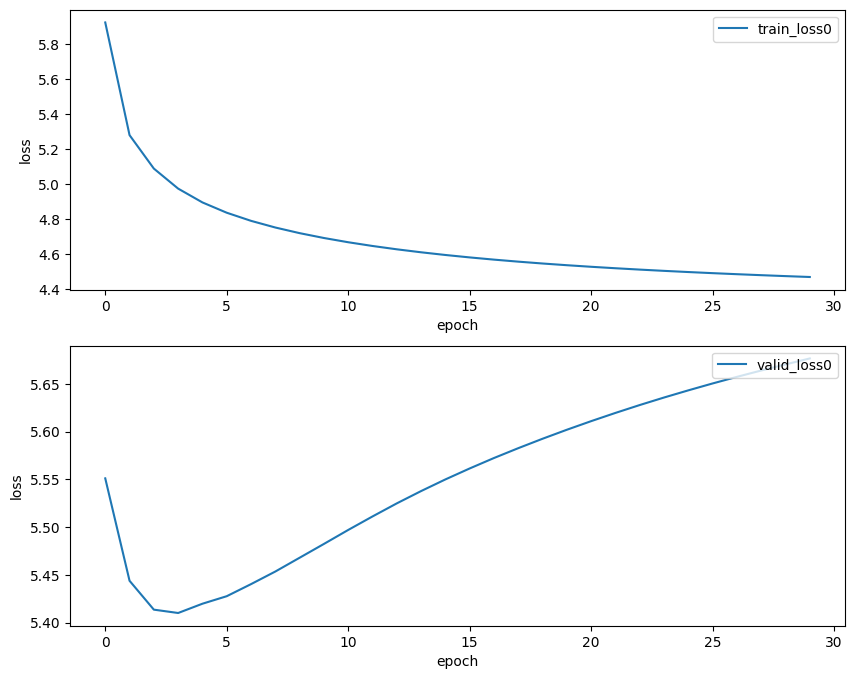

In [27]:
# excise 3.4 transformer neural network (optional)
learning_rate = 0.002
num_epochs = 30
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 1024
num_layers = 1
fig, ax = plt.subplots(2, 1, figsize=(10, 8))


for number_decoder_layers in range(0,1,3):
    # Train model
    model_6 = transformer(vocab_size, embedding_dim, hidden_dim, num_layers, number_decoder_layers).to(device)
    train_losses_6, valid_losses_6, train_perplexities_6, valid_perplexities_6 = train(model=model_6,
                                                                            model_type='LSTM',
                                                                                train_data=train_data,
                                                                                valid_data=valid_data,
                                                                                vocab_size=vocab_size, 
                                                                                batch_size=batch_size,
                                                                                seq_len=seq_len,
                                                                                num_epochs=num_epochs, 
                                                                                learning_rate=learning_rate, 
                                                                                device=device,
                                                                                clip=0.5
                                                                                )
    ax[0].plot(train_losses_6, label='train_loss'+str(number_decoder_layers))
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(loc='upper right')

    ax[1].plot(valid_losses_6, label='valid_loss'+str(number_decoder_layers))
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc='upper right')




In [32]:
# Test
test_loss_6, test_perplexity_6 = evaluate(model_6, 'LSTM', test_data, vocab_size, batch_size, seq_len, device)
print('test_loss =', '{:.4f}'.format(test_loss_6), 'test_perplexity =', '{:.4f}'.format(test_perplexity_6))

# Generate text
sample(model_6, 'LSTM', int_to_word, 50, vocab, device, start='after years of')


test_loss = 4.4686 test_perplexity = 87.2302


'after years of a two dealers an the officers the ruling taxes a the what hurricane it his <unk> powerful at the a went <unk> town tuesday <unk> july the the oct. telling N commissioned initial speculation resigning revamping ford a two a being posting the each the salomon N'

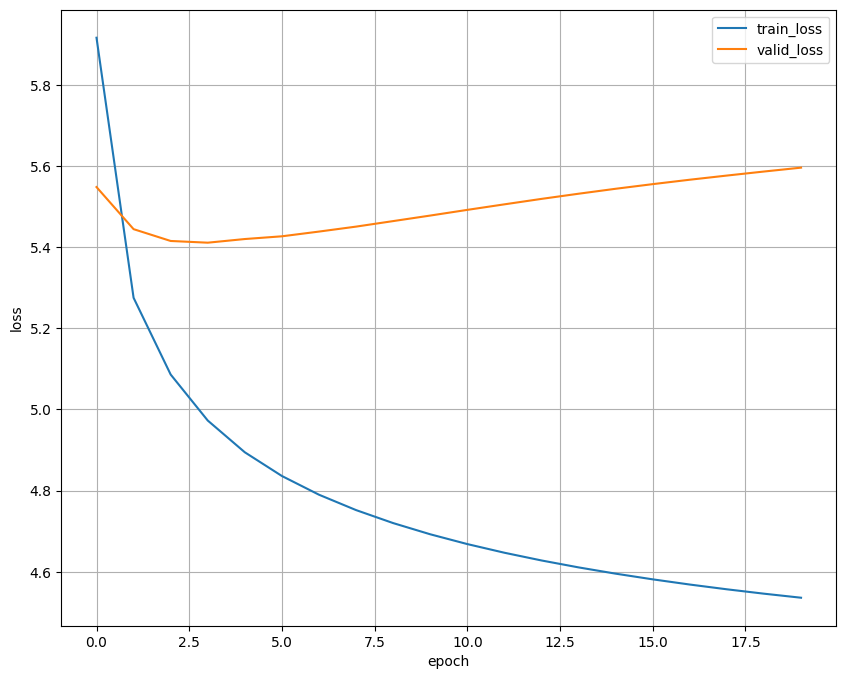

In [278]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses_6, label='train_loss')
plt.plot(valid_losses_6, label='valid_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()